<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part5/P5_Ch08_CH08_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### setting

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
import os
import sys
from datetime import datetime

drive_project_root = "/content/drive/MyDrive/#fastcampus"
sys.path.append(drive_project_root)
!pip install -r "/content/drive/MyDrive/#fastcampus/requirements.txt"

In [2]:
!pip install portalocker

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Aug  2 06:31:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install omegaconf
!pip install torch_optimizer
!pip install wandb
!pip install efficientnet_pytorch==0.7.1
!pip install hydra-core==1.1
!pip install pytorch-lightning
!pip install --upgrade torchmetrics
!pip install --upgrade pytorch-lightning

In [5]:
# For data loading.
from typing import List
from typing import Dict
from typing import Union
from typing import Any
from typing import Optional
from typing import Iterable
from abc import abstractmethod
from abc import ABC
from datetime import datetime
from functools import partial
from collections import Counter
from collections import OrderedDict
import math
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.nn import Transformer
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pprint import pprint

from torchtext import data
from torchtext import datasets

from torchtext.datasets import Multi30k, multi30k

from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset
from torchtext.vocab import Vocab, build_vocab_from_iterator, vocab
import spacy

# For configuration
from omegaconf import DictConfig
from omegaconf import OmegaConf
import hydra
from hydra.core.config_store import ConfigStore

# For logger
from torch.utils.tensorboard import SummaryWriter
import wandb
os.environ["WANDB_START_METHOD"]="thread"

In [6]:

%cd /content/drive/MyDrive/#fastcampus
from data_utils import dataset_split
from config_utils import flatten_dict
from config_utils import register_config
from config_utils import configure_optimizers_from_cfg
from config_utils import get_loggers
from config_utils import get_callbacks
%cd /content


/content/drive/MyDrive/#fastcampus
/content


In [ ]:
# download eng/d data.
!python -m spacy download en
!python -m spacy download en_core_web_sm
!python -m spacy download de
!python -m spacy download de_core_news_sm

# Transformer-based RNN Seq2Seq
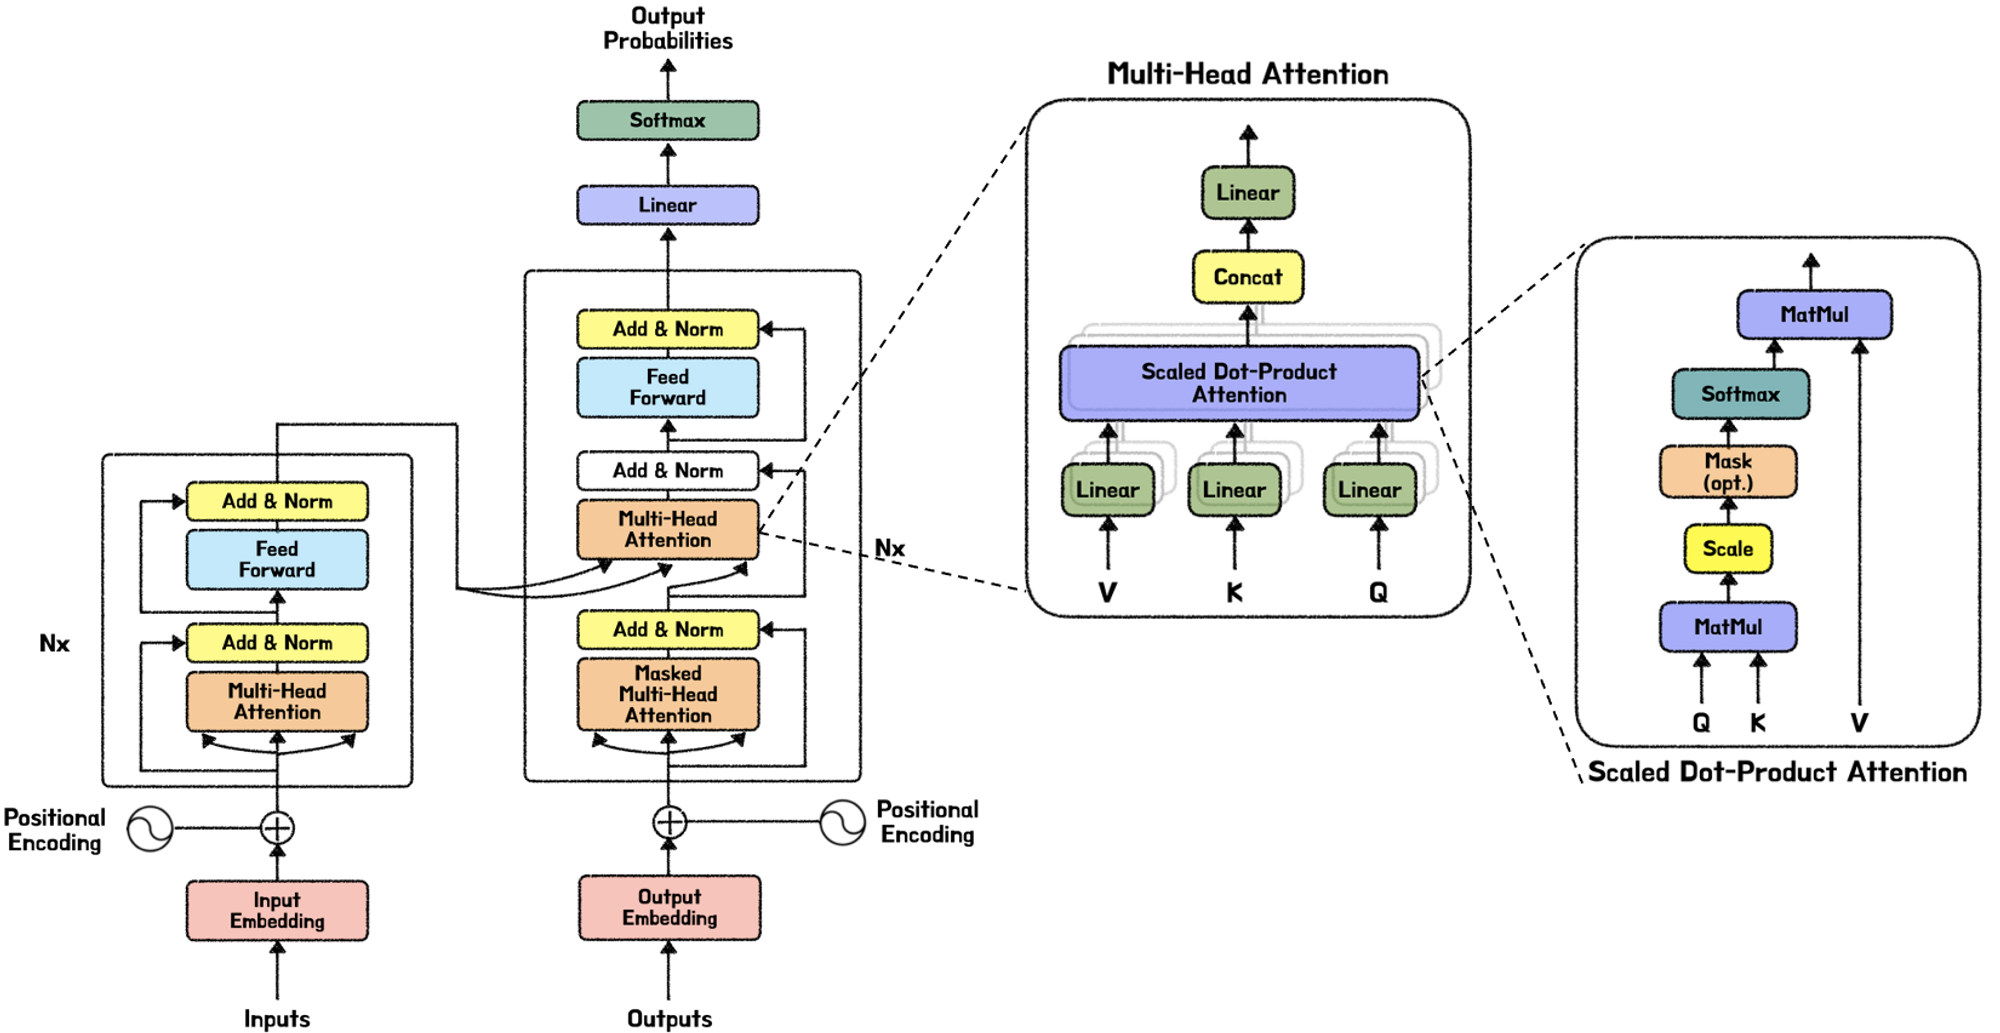

### 데이터 추출해오기
- 원래 torchtext의 Multi30k dataloader를 사용했으나, 서버터짐으로 인해 직접 추출후 병합하여 데이터로 사용

In [ ]:
!git clone --recursive https://github.com/multi30k/dataset.git multi30k-dataset

In [9]:
# ## train data로 저장

import gzip

def read_lines_from_gzip(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        return [line.strip() for line in file]

file_path_en = '/content/multi30k-dataset/data/task1/raw/train.en.gz'
file_path_de = '/content/multi30k-dataset/data/task1/raw/train.de.gz'

lines_en = read_lines_from_gzip(file_path_en)
lines_de = read_lines_from_gzip(file_path_de)

# 두 리스트를 튜플 형태로 묶지 않고 개별적으로 사용하여 train_data 생성
train_data = [(de_line, en_line) for de_line, en_line in zip(lines_de, lines_en)]

# test_data를 파일로 저장
with open('/content/data/train_data.txt', 'w', encoding='utf-8') as file:
    for de_line, en_line in train_data:
        file.write(f'{de_line}\t{en_line}\n')


In [10]:

import gzip

def read_lines_from_gzip(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        return [line.strip() for line in file]

file_path_en = '/content/multi30k-dataset/data/task1/raw/val.en.gz'
file_path_de = '/content/multi30k-dataset/data/task1/raw/val.de.gz'

lines_en = read_lines_from_gzip(file_path_en)
lines_de = read_lines_from_gzip(file_path_de)

# 두 리스트를 튜플 형태로 묶지 않고 개별적으로 사용하여 train_data 생성
val_data = [(de_line, en_line) for de_line, en_line in zip(lines_de, lines_en)]

# test_data를 파일로 저장
with open('/content/data/val_data.txt', 'w', encoding='utf-8') as file:
    for de_line, en_line in val_data:
        file.write(f'{de_line}\t{en_line}\n')


In [11]:

import gzip

def read_lines_from_gzip(file_path):
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        return [line.strip() for line in file]

file_path_en = '/content/multi30k-dataset/data/task1/raw/test_2016_flickr.en.gz'
file_path_de = '/content/multi30k-dataset/data/task1/raw/test_2016_flickr.de.gz'

lines_en = read_lines_from_gzip(file_path_en)
lines_de = read_lines_from_gzip(file_path_de)

# 두 리스트를 튜플 형태로 묶지 않고 개별적으로 사용하여 train_data 생성
test_data = [(de_line, en_line) for de_line, en_line in zip(lines_de, lines_en)]

# test_data를 파일로 저장
with open('/content/data/test_data.txt', 'w', encoding='utf-8') as file:
    for de_line, en_line in test_data:
        file.write(f'{de_line}\t{en_line}\n')


In [12]:
# train dataloader

def read_lines_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return [line.strip() for line in file]

# 'test_data.txt' 파일을 읽어서 리스트로 변환
train_data_file_path = '/content/data/train_data.txt'
train_data_lines = read_lines_from_file(train_data_file_path)

# 각 문장을 튜플로 묶어서 리스트를 만듦
train_data = [tuple(line.split('\t')) for line in train_data_lines]

# to_map_style_dataset 함수로 변환
from torch.utils.data import Dataset, DataLoader

class TrainDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

train_dataset = TrainDataset(train_data)
train_data = DataLoader(train_dataset, batch_size=1, shuffle=False)

# train_data = to_map_style_dataset(train_data)


In [13]:
# val dataloader
def read_lines_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return [line.strip() for line in file]

# 'val_data.txt' 파일을 읽어서 리스트로 변환
val_data_file_path = '/content/data/val_data.txt'
val_data_lines = read_lines_from_file(val_data_file_path)

# 각 문장을 튜플로 묶어서 리스트를 만듦
val_data = [tuple(line.split('\t')) for line in val_data_lines]

# to_map_style_dataset 함수로 변환
from torch.utils.data import Dataset, DataLoader

class ValDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

val_dataset = ValDataset(val_data)
val_data = DataLoader(val_dataset, batch_size=1, shuffle=False)

# val_data = to_map_style_dataset(val_data)


In [14]:
# test dataloader
def read_lines_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return [line.strip() for line in file]

# 'test_data.txt' 파일을 읽어서 리스트로 변환
test_data_file_path = '/content/data/test_data.txt'
test_data_lines = read_lines_from_file(test_data_file_path)

# 각 문장을 튜플로 묶어서 리스트를 만듦
test_data = [tuple(line.split('\t')) for line in test_data_lines]

# to_map_style_dataset 함수로 변환
from torch.utils.data import Dataset, DataLoader

class TestDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

test_dataset = TestDataset(test_data)
test_data = DataLoader(test_dataset, batch_size=1, shuffle=False)

# test_data = to_map_style_dataset(test_data)


## tokenizing

In [15]:
# practice data first go to dataconfig

# data configs
data_spacy_de_en_cfg = {
    "name": "spacy_de_en",
    "data_root": os.path.join(os.getcwd(), "data"),
    "tokenizer": "spacy",
    "src_lang": "de",
    "tgt_lang": "en",
    "src_index": 0,
    "tgt_index": 1,
    "vocab": {
        "special_symbol2index": {
            # Define special symbols and indices
            # UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
            # Make sure the tokens are in order of their indices to properly insert them in vocab
            '<unk>': 0,
            '<pad>': 1,
            '<bos>': 2,
            '<eos>': 3,
        },
        "special_first": True,
        "min_freq": 2
    }
}

data_cfg = OmegaConf.create(data_spacy_de_en_cfg)



In [16]:

def get_token_transform(data_cfg: DictConfig) -> dict:
    token_transform = {}
    token_transform[data_cfg.src_lang] = get_tokenizer(
        data_cfg.tokenizer, language=data_cfg.src_lang
    )
    token_transform[data_cfg.tgt_lang] = get_tokenizer(
        data_cfg.tokenizer, language=data_cfg.tgt_lang
    )
    return token_transform

token_transform = get_token_transform(data_cfg)

/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


In [17]:

# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, lang: str, lang2index: Dict[str, int]) -> List[str]:
    for data_sample in data_iter:
        # 데이터 샘플을 언팩킹하여 해당 언어 데이터를 추출
        data_sample_lang = data_sample[0 if lang == 'de' else 1]
        for sentence in data_sample_lang:
            # 문장이 이미 토큰화되어 있으므로, 바로 토큰을 반환
            yield token_transform[lang](sentence)


def get_vocab_transform(data_cfg: DictConfig) -> dict:
    vocab_transform = {}
    for ln in [data_cfg.src_lang, data_cfg.tgt_lang]:
        # Training data Iterator
        train_iter = iter(train_data)
        # Create torchtext's Vocab object
        vocab_transform[ln] = build_vocab_from_iterator(
            yield_tokens(
                train_iter,
                ln,
                {
                    data_cfg.src_lang: data_cfg.src_index,
                    data_cfg.tgt_lang: data_cfg.tgt_index
                }
            ),
            min_freq=data_cfg.vocab.min_freq,
            specials=list(data_cfg.vocab.special_symbol2index.keys()),
            special_first=data_cfg.vocab.special_first,
        )

    # Set UNK_IDX as the default index. This index is returned when the token is not found.
    # If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
    for ln in [data_cfg.src_lang, data_cfg.tgt_lang]:
        vocab_transform[ln].set_default_index(
            data_cfg.vocab.special_symbol2index["<unk>"]
        )
    return vocab_transform

vocab_transform = get_vocab_transform(data_cfg)

In [18]:
print(vocab_transform["de"]["<unk>"])
print(vocab_transform["en"]["<unk>"])
print(vocab_transform["en"]["hello"], vocab_transform["en"]["world"])

0
0
5465 1870


In [19]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int], bos_index: int, eos_index: int):
    return torch.cat((torch.tensor([bos_index]),
                      torch.tensor(token_ids),
                      torch.tensor([eos_index])))

# src and tgt language text transforms to convert raw strings into tensors indices
def get_text_transform(data_cfg):
    text_transform = {}
    for ln in [data_cfg.src_lang, data_cfg.tgt_lang]:
        text_transform[ln] = sequential_transforms(
            token_transform[ln], #Tokenization
            vocab_transform[ln], #Numericalization
            partial(
                tensor_transform,
                bos_index=data_cfg.vocab.special_symbol2index["<bos>"],
                eos_index=data_cfg.vocab.special_symbol2index["<eos>"],
            )
        ) # Add BOS/EOS and create tensor
    return text_transform

text_transform = get_text_transform(data_cfg)

In [20]:
print(text_transform["en"]("hello"))
print(text_transform["en"]("hello,"))
print(text_transform["en"]("hello, how"))
print(text_transform["en"]("hello, how are you ?"))

tensor([   2, 5465,    3])
tensor([   2, 5465,   15,    3])
tensor([   2, 5465,   15,  889,    3])
tensor([   2, 5465,   15,  889,   17, 1328, 2470,    3])


In [86]:

def collate_fn(batch, data_cfg):

    src_texts, tgt_texts = [], []
    for sample in batch:
        src_texts.append(text_transform[cfg.data.src_lang](sample[0][0].rstrip("\n")))
        tgt_texts.append(text_transform[cfg.data.tgt_lang](sample[1][0].rstrip("\n")))

    src_batch = pad_sequence(src_texts, padding_value=data_cfg.vocab.special_symbol2index["<pad>"])
    tgt_batch = pad_sequence(tgt_texts, padding_value=data_cfg.vocab.special_symbol2index["<pad>"])

    return src_batch, tgt_batch


def get_collate_fn(cfg: DictConfig):
    return partial(collate_fn, data_cfg=cfg.data)

def get_multi30k_dataloader(
    split_mode: str, batch_size: int, collate_fn
):
    if split_mode == 'train':
      iter = train_data
    elif split_mode == 'val':
      iter = val_data
    else :
      iter = test_data

    dataset = to_map_style_dataset(iter)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, collate_fn=collate_fn
    )
    return dataloader



In [88]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [89]:
def _text_postprocessing(res: List[str]) -> str:
    if "<eos>" in res:
        res = res[:res.index("<eos>")]
    if "<pad>" in res:
        res = res[:res.index("<pad>")]
    res = " ".join(res).replace("<bos>", "")
    return res


class BaseTranslateLightningModule(pl.LightningModule):
    def __init__(self, cfg: DictConfig):
        super().__init__()
        self.cfg = cfg
        self.loss_function = torch.nn.CrossEntropyLoss(
            ignore_index=cfg.data.vocab.special_symbol2index["<pad>"]
        )

    def configure_optimizers(self):
        self._optimizers, self._schedulers = configure_optimizers_from_cfg(
            self.cfg, self
        )
        return self._optimizers, self._schedulers

    @abstractmethod
    def forward(self, src, tgt, teacher_forcing_ratio: float):
        raise NotImplementedError()

    def _forward(self, src, tgt, mode: str, teacher_forcing_ratio: float = 0.5):
        # teacher forcing:
        # seq2seq 에서 많이 쓰인다.
        # src -> tgt autoregressive 학습하면, 맨 최초는 학습을 빠르게 한다. 근데, 미래부분 학습은? (앞부분 될때까지 기다리기 너무 힘들다...)
        # 랜덤으로 미래 정보도 조금 둬서 뒤에 있는 정보도 학습이 가능하게 하자 !
        # 근데 0.5다? ==> 0.5 확률로 teacher_forcing을 하겠다 !

        assert mode in ["train", "val", "test"]


        # get predictions
        # teacher_forcing 용 input -->
        tgt_inputs = tgt[:-1, :] # delete ends for teacher forcing inputs.
        outputs = self(src, tgt_inputs, teacher_forcing_ratio=teacher_forcing_ratio)
        tgt_outputs = tgt[1:, :] # delete start tokens.

        loss = self.loss_function(
            outputs.reshape(-1, outputs.shape[-1]),  # [[batch X Seq_size], other_output_shape]
            tgt_outputs.reshape(-1),
        )

        logs_detail = {
            f"{mode}_src": src,
            f"{mode}_tgt": tgt,
            f"{mode}_results": outputs,
        }

        if mode in ["val", "test"]:
            _, tgt_results = torch.max(outputs, dim=2)

            src_texts = []
            tgt_texts = []
            res_texts = []

            # convert [L X B X others] --> [B X L X others]
            for src_i in torch.transpose(src, 0, 1).detach().cpu().numpy().tolist():
                res = vocab_transform[self.cfg.data.src_lang].lookup_tokens(src_i)
                src_texts.append(_text_postprocessing(res))

            for tgt_i in torch.transpose(tgt, 0, 1).detach().cpu().numpy().tolist():
                res = vocab_transform[self.cfg.data.tgt_lang].lookup_tokens(tgt_i)
                tgt_texts.append(_text_postprocessing(res))

            for tgt_res_i in torch.transpose(tgt_results, 0, 1).detach().cpu().numpy().tolist():
                res = vocab_transform[self.cfg.data.tgt_lang].lookup_tokens(tgt_res_i)
                res_texts.append(_text_postprocessing(res))

            text_result_summary = {
                f"{mode}_src_text": src_texts,
                f"{mode}_tgt_text": tgt_texts,
                f"{mode}_results_text": res_texts,
            }
            print(f"{self.global_step} step: \n src_text: {src_texts[0]}, \n tgt_text: {tgt_texts[0]}, \n result_text: {res_texts[0]}")
            logs_detail.update(text_result_summary)

        return {f"{mode}_loss": loss}, logs_detail


    def training_step(self, batch, batch_idx):
        src, tgt = batch[0], batch[1]
        logs, _ = self._forward(src, tgt, "train", self.cfg.model.teacher_forcing_ratio)
        self.log_dict(logs)
        logs["loss"] = logs["train_loss"]
        return logs

    def validation_step(self, batch, batch_idx):
        src, tgt = batch[0], batch[1]
        logs, logs_detail = self._forward(src, tgt, "val", 0.0)
        self.log_dict(logs)
        logs["loss"] = logs["val_loss"]
        logs.update(logs_detail)
        return logs

    def test_step(self, batch, batch_idx):
        src, tgt = batch[0], batch[1]
        logs, logs_detail = self._forward(src, tgt, "test", 0.0)
        self.log_dict(logs)
        logs["loss"] = logs["test_loss"]
        logs.update(logs_detail)
        return logs


class TransformerTranslateLightningModule(BaseTranslateLightningModule):
    def __init__(self, cfg: DictConfig):
        super().__init__(cfg)

    @abstractmethod
    def forward(self, src, tgt):
        raise NotImplementedError()

    def _forward(self, src, tgt, mode: str):
        # teacher forcing:
        # seq2seq 에서 많이 쓰인다.
        # src -> tgt autoregressive 학습하면, 맨 최초는 학습을 빠르게 한다. 근데, 미래부분 학습은? (앞부분 될때까지 기다리기 너무 힘들다...)
        # 랜덤으로 미래 정보도 조금 둬서 뒤에 있는 정보도 학습이 가능하게 하자 !
        # 근데 0.5다? ==> 0.5 확률로 teacher_forcing을 하겠다 !

        assert mode in ["train", "val", "test"]


        # get predictions
        # teacher_forcing 용 input -->
        tgt_inputs = tgt[:-1, :] # delete ends
        outputs = self(src, tgt_inputs)
        tgt_outputs = tgt[1:, :] # delete start tokens.

        loss = self.loss_function(
            outputs.reshape(-1, outputs.shape[-1]),  # [[batch X Seq_size], other_output_shape]
            tgt_outputs.reshape(-1),
        )

        logs_detail = {
            f"{mode}_src": src,
            f"{mode}_tgt": tgt,
            f"{mode}_results": outputs,
        }

        if mode in ["val", "test"]:
            _, tgt_results = torch.max(outputs, dim=2)

            src_texts = []
            tgt_texts = []
            res_texts = []

            # convert [L X B X others] --> [B X L X others]
            for src_i in torch.transpose(src, 0, 1).detach().cpu().numpy().tolist():
                res = vocab_transform[self.cfg.data.src_lang].lookup_tokens(src_i)
                src_texts.append(_text_postprocessing(res))

            for tgt_i in torch.transpose(tgt, 0, 1).detach().cpu().numpy().tolist():
                res = vocab_transform[self.cfg.data.tgt_lang].lookup_tokens(tgt_i)
                tgt_texts.append(_text_postprocessing(res))

            for tgt_res_i in torch.transpose(tgt_results, 0, 1).detach().cpu().numpy().tolist():
                res = vocab_transform[self.cfg.data.tgt_lang].lookup_tokens(tgt_res_i)
                res_texts.append(_text_postprocessing(res))

            text_result_summary = {
                f"{mode}_src_text": src_texts,
                f"{mode}_tgt_text": tgt_texts,
                f"{mode}_results_text": res_texts,
            }
            print(f"{self.global_step} step: \n src_text: {src_texts[0]}, \n tgt_text: {tgt_texts[0]}, \n result_text: {res_texts[0]}")
            logs_detail.update(text_result_summary)

        return {f"{mode}_loss": loss}, logs_detail


    def training_step(self, batch, batch_idx):
        src, tgt = batch[0], batch[1]
        logs, _ = self._forward(src, tgt, "train")
        self.log_dict(logs)
        logs["loss"] = logs["train_loss"]
        return logs

    def validation_step(self, batch, batch_idx):
        src, tgt = batch[0], batch[1]
        logs, logs_detail = self._forward(src, tgt, "val")
        self.log_dict(logs)
        logs["loss"] = logs["val_loss"]
        logs.update(logs_detail)
        return logs

    def test_step(self, batch, batch_idx):
        src, tgt = batch[0], batch[1]
        logs, logs_detail = self._forward(src, tgt, "test")
        self.log_dict(logs)
        logs["loss"] = logs["test_loss"]
        logs.update(logs_detail)
        return logs


In [90]:
# weight initialization
def init_weights(model: Union[nn.Module, pl.LightningModule]):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


In [91]:
class LSTMEncoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        embed_dim: int,
        hidden_dim: int,
        n_layers: int,
        dropout: float
    ):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout = dropout)

        self.dropout = nn.Dropout(dropout)

        self.apply(init_weights)

    def forward(self, src):
        # src = [src len, batch size]
        embedded = self.dropout(self.embedding(src))

        # embedded = [src len, batch size, emb dim]
        outputs, (hidden, cell) = self.rnn(embedded)

        # outputs = [src len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        # outputs are always from the top hidden layer
        return hidden, cell


class LSTMDecoder(nn.Module):
    def __init__(
        self,
        output_dim: int,
        embed_dim: int,
        hidden_dim: int,
        n_layers: int,
        dropout: float,
    ):
        super().__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        # n directions in the decoder will both always be 1, therefore:
        # hidden = [n layers, batch size, hid dim]
        # context = [n layers, batch size, hid dim]

        input = input.unsqueeze(0)

        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))

        # embedded = [1, batch size, emb dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        # output = [seq len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        # seq len and n directions will always be 1 in the decoder, therefore:
        # output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]

        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch size, output dim]

        return prediction, hidden, cell


class LSTMSeq2Seq(BaseTranslateLightningModule):
    def __init__(self, cfg: DictConfig):
        super().__init__(cfg)
        # encoder, decoder, device

        self.encoder = LSTMEncoder(**cfg.model.enc)
        self.decoder = LSTMDecoder(**cfg.model.dec)
        # self.device = device

        assert self.encoder.hidden_dim == self.decoder.hidden_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert self.encoder.n_layers == self.decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

        self.apply(init_weights)

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):

        # src = [src len, batch size]
        # trg = [trg len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)

        #first input to the decoder is the <sos> tokens
        input = trg[0,:]

        for t in range(1, trg_len):

            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output

            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio

            #get the highest predicted token from our predictions
            top1 = output.argmax(1)

            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs


In [92]:
# Concat; Addictive Attention 기반의 모델 새로 정의.
# encoder, decoder rnn 이 다를 수 있다 !

class BidirectionalGRUEncoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        embed_dim: int,
        enc_hidden_dim: int,
        dec_hidden_dim: int,
        n_layers: int,
        dropout: float
    ):
        super().__init__()
        self.input_dim = input_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.GRU(embed_dim, enc_hidden_dim, n_layers, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(enc_hidden_dim * 2, dec_hidden_dim)
        self.dropout = nn.Dropout(dropout)

        # initialization of weights
        self.apply(init_weights)

    def forward(self, src):

        # src = [seq_len, batch_size]
        embedded = self.dropout(self.embedding(src)) # [seq_len, batch_size, emb_dim]

        outputs, hidden = self.rnn(embedded)
        # outputs = [seq_len, batch_size, hidden_dim * n directional]
        # hidden = [n layers * n directions, batch_size, hidden_dim]

        # hidden -> [forward_1, backward_1, forward_2, backward_2, ..]
        # 우리가 필요한건 맨 마지막 layer의 forward backward 두개 concat 한개 필요.
        # => torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)

        # encoder RNNs fed through a linear layer to connect decoder.
        hidden = torch.tanh(self.fc(
            torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        ))

        return outputs, hidden


class ConcatAttention(nn.Module):
    def __init__(self, enc_hidden_dim: int, dec_hidden_dim: int):
        super().__init__()

        self.attn = nn.Linear((enc_hidden_dim * 2) + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):

        # hidden = [batch_size, dec_hidden_dim] => from decoder. (query)
        # encoder_outputs = [src_len, batch_size, enc_hidden_dim * 2] (key, value)

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        # repeat decoder hidden state src_len times ...
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # hidden: [batch_size, src_len, dec_hidden_dim]
        # encoder_outputs = [barch_size, src_len, enc_hidden_dim * 2]

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))

        # energy = [batch_size, src_len, dec_hidden_dim]

        attention = self.v(energy).squeeze(2)

        # attention = [batch_size, src_len]

        return F.softmax(attention, dim=1)


class AttentionalRNNDecoder(nn.Module):
    def __init__(
        self,
        output_dim: int,
        embed_dim: int,
        enc_hidden_dim: int,
        dec_hidden_dim: int,
        n_layers: int,
        dropout: float,
        attention: nn.Module
    ):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, embed_dim)
        self.rnn = nn.GRU((enc_hidden_dim * 2) + embed_dim, dec_hidden_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear((enc_hidden_dim*2) + dec_hidden_dim + embed_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):

        # input [batch size] # start_token
        # hidden [batch_size, dec_hidden_dim]
        # encoder_outputs [src_len, batch_size, enc_hidden_dim*2]

        input = input.unsqueeze(0) # input = [1, batch_size]

        embedded = self.dropout(self.embedding(input)) # 1, batch_size, embed_dim

        a = self.attention(hidden, encoder_outputs) # [batch_size, src_len]
        a = a.unsqueeze(1) # [batch_size, 1, src_len]

        encoder_outputs = encoder_outputs.permute(1, 0, 2) # [batch_size, src_len, enc_hidden_dim*2]
        weighted = torch.bmm(a, encoder_outputs) # [batch_size, 1, enc_hidden_dim*2]
        weighted = weighted.permute(1, 0, 2) # [1, batch_size, enc_hidden_dim*2]

        rnn_input = torch.cat((embedded, weighted), dim=2) # [1, batch_size, (enc_hidden_dim*2 + embed_dim)]

        # hidden_unsqueeze: [1, batch_size, dec_hidden_dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq_len, batch_size, dec_hidden_dim * n directions] => [1, batch_size, dec_hidden_dim]
        # hidden = [n layers * n_directions, batch_size, dec_hidden_dims] => [1, batch_size, dec_hidden_dim]

        if not (output == hidden).all():
            raise AssertionError()

        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1)) # [batch_size, output_dim]

        return prediction, hidden.squeeze(0)



class AttentionBasedSeq2Seq(BaseTranslateLightningModule):
    def __init__(self, cfg: DictConfig):
        super().__init__(cfg)

        self.encoder = BidirectionalGRUEncoder(**cfg.model.enc)
        self.attention = ConcatAttention(**cfg.model.attention)
        self.decoder = AttentionalRNNDecoder(
            attention=self.attention, **cfg.model.dec
        )

    def forward(self, src, tgt, teacher_forcing_ratio: float = 0.5):

        # src, tgt = [seq_len (can be different), batch_size]
        # for val, test teacher forcing should be 0.0

        batch_size = tgt.shape[1]
        tgt_len = tgt.shape[0]
        tgt_vocab_size = self.decoder.output_dim

        # tensor to store decoder outputs
        outputs = torch.zeros(tgt_len, batch_size, tgt_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        # start_token_input (<sos> tokens)
        input = tgt[0, :]

        for t in range(1, tgt_len):

            # get one cell's output
            output, hidden = self.decoder(input, hidden, encoder_outputs)

            # set to all outputs results
            outputs[t] = output

            # decide whether going to use teacher forcing or not.
            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(1)

            input = tgt[t] if teacher_force else top1

        return outputs


## transformer model define

In [93]:
# 1. tokenembedding
# 2. positional encoding
# 3. nn.Transformer

class PositionalEncoding(nn.Module):
  def __init__(
      self,
      embed_size : int,
      dropout : float,
      maxlen :int= 5000
  ):
    super().__init__()
    den = torch.exp(-torch.arange(0, embed_size, 2)*math.log(10000) / embed_size)
    pos = torch.arange(0, maxlen).reshape(maxlen, 1)
    pos_embedding = torch.zeros((maxlen, embed_size))

    # sin: 2i
    pos_embedding[:, 0::2] = torch.sin(pos * den)
    # cos: 2i+1
    pos_embedding[:, 1::2] = torch.cos(pos * den)
    pos_embedding = pos_embedding.unsqueeze(-2)

    self.dropout = nn.Dropout(dropout)
    self.register_buffer("pos_embedding", pos_embedding)



  def forward(self, token_embedding : torch.Tensor):
    return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

class Tokenembedding(nn.Module):
  def __init__(
      self,
      vocab_size:int,
      embed_size : int
  ):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_size)
    self.embed_size = embed_size

  def forward(self, tokens : torch.Tensor):
    return self.embedding(tokens.long()) * math.sqrt(self.embed_size) # scaling for emb_size

class TransformerSeq2Seq(TransformerTranslateLightningModule):
  def __init__(self, cfg : DictConfig):
    super().__init__(cfg)
    self.cfg = cfg
    num_encoder_layers = self.cfg.model.num_encoder_layers
    num_decoder_layers = self.cfg.model.num_decoder_layers
    embed_size = self.cfg.model.embed_size
    nhead = self.cfg.model.nhead
    src_vocab_size = self.cfg.model.src_vocab_size
    tgt_vocab_size = self.cfg.model.tgt_vocab_size
    dim_feedforward = self.cfg.model.dim_feedforward
    dropout = self.cfg.model.dropout

    self.transformer = Transformer(
        d_model = embed_size,
        nhead = nhead,
        num_encoder_layers= num_encoder_layers,
        num_decoder_layers = num_decoder_layers,
        dim_feedforward=dim_feedforward,
        dropout = dropout
    )
    self.generator = nn.Linear(embed_size, tgt_vocab_size)
    self.src_token_emb = Tokenembedding(src_vocab_size, embed_size )
    self.tgt_token_emb = Tokenembedding(tgt_vocab_size, embed_size )
    self.positional_encoding = PositionalEncoding(embed_size, dropout = dropout)

  def generate_square_subset_mask(self,sz : int):
    mask = (torch.triu(torch.ones((sz, sz), device =self.device)) == 1).transpose(0,1)
    mask = mask.float().masked_fill(mask ==0 , float("-inf")).masked_fill(mask ==1, float(0.0))
    return mask

  def create_mask(self, src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = self.generate_square_subset_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device = self.device).type(torch.bool)

    src_padding_mask = (src ==self.cfg.data.vocab.special_symbol2index["<pad>"]).transpose(0,1)
    tgt_padding_mask = (tgt ==self.cfg.data.vocab.special_symbol2index["<pad>"]).transpose(0,1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask


  def forward(self, src : torch.Tensor, tgt: torch.Tensor):
    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = self.create_mask(src, tgt)
    memory_key_padding_mask = src_padding_mask

    src_emb = self.positional_encoding(self.src_token_emb(src))
    tgt_emb = self.positional_encoding(self.tgt_token_emb(tgt))
    outs = self.transformer(
        src_emb,
        tgt_emb,
        src_mask,
        tgt_mask,
        None,
        src_padding_mask,
        tgt_padding_mask,
        memory_key_padding_mask
    )
    return self.generator(outs)

  def encode(self, src : torch.Tensor, src_mask : torch.Tensor):
    return self.transformer.encoder(self.positional_encoding(self.src_token_emb(src)), src_mask)

  def decode(self, tgt : torch.Tensor, memory : torch.Tensor, tgt_mask : torch.Tensor):
    return self.transformer.decoder(self.positional_encoding(self.tgt_token_emb(tgt)), memory, tgt_mask)

In [94]:

# data configs
data_spacy_de_en_cfg = {
    "name": "spacy_de_en",
    "data_root": os.path.join(os.getcwd(), "data"),
    "tokenizer": "spacy",
    "src_lang": "de",
    "tgt_lang": "en",
    "src_index": 0,
    "tgt_index": 1,
    "vocab": {
        "special_symbol2index": {
            # Define special symbols and indices
            # UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
            # Make sure the tokens are in order of their indices to properly insert them in vocab
            '<unk>': 0,
            '<pad>': 1,
            '<bos>': 2,
            '<eos>': 3,
        },
        "special_first": True,
        "min_freq": 2
    }
}

data_cfg = OmegaConf.create(data_spacy_de_en_cfg)

# get dataset
# data_root = os.path.join(os.getcwd(), "data")
train_data, valid_data, test_data = train_data, val_data, test_data

token_transform = get_token_transform(data_cfg)
vocab_transform = get_vocab_transform(data_cfg)

In [95]:
# model configs
model_translate_lstm_seq2seq_cfg = {
    "name": "LSTMSeq2Seq",
    "out_dim": len(vocab_transform[data_cfg.src_lang]),
    "enc": {
        "input_dim": len(vocab_transform[data_cfg.src_lang]),
        "embed_dim": 256,
        "hidden_dim": 256,
        "n_layers": 2,
        "dropout": 0.5,
    },
    "dec": {
        "output_dim": len(vocab_transform[data_cfg.tgt_lang]),
        "embed_dim": 256,
        "hidden_dim": 256,
        "n_layers": 2,
        "dropout": 0.5,
    },
    "teacher_forcing_ratio": 0.5
}

model_translate_attention_based_seq2seq_cfg = {
    "name": "AttentionBasedSeq2Seq",
    "enc": {
        "input_dim": len(vocab_transform[data_cfg.src_lang]),
        "embed_dim": 256,
        "enc_hidden_dim": 512,
        "dec_hidden_dim": 512,
        "n_layers": 1,
        "dropout": 0.5,
    },
    "dec": {
        "output_dim": len(vocab_transform[data_cfg.tgt_lang]),
        "embed_dim": 256,
        "enc_hidden_dim": 512,
        "dec_hidden_dim": 512,
        "n_layers": 1,
        "dropout": 0.5,
    },
    "attention" : {
        "enc_hidden_dim": 512,
        "dec_hidden_dim": 512,
    },
    "teacher_forcing_ratio": 0.5
}

model_translate_transformer_seq2seq_cfg ={
    "name" : "TransformerSeq2Seq",
    "num_encoder_layers" : 3,
    "num_decoder_layers" : 3,
    "embed_size" : 512,
    "nhead" : 8,
    "src_vocab_size" : len(vocab_transform[data_cfg.src_lang]),
    "tgt_vocab_size" : len(vocab_transform[data_cfg.tgt_lang]),
    "dim_feedforward" : 512,
    "dropout" : 0.5,

}


# optimizer configs
opt_cfg = {
    "optimizers": [
        {
            "name": "RAdam",
            "kwargs": {
                "lr": 1e-3,
            }
        }
    ],
    "lr_schedulers": [
        {
            "name": None,
            "kwargs": {
                "warmup_end_steps": 1000
            }
        },
    ]
}

_merged_cfg_presets = {
    "LSTM_seq2seq_de_en_translate": {
        "opt": opt_cfg,
        "data": data_spacy_de_en_cfg,
        "model": model_translate_lstm_seq2seq_cfg,
    },
    "attention_based_seq2seq_de_en_translate": {
        "opt": opt_cfg,
        "data": data_spacy_de_en_cfg,
        "model": model_translate_attention_based_seq2seq_cfg,
    },

    "Transformer_seq2seq_de_en_translate": {
        "opt": opt_cfg,
        "data": data_spacy_de_en_cfg,
        "model": model_translate_transformer_seq2seq_cfg,
    },
}

# clear config instance first
hydra.core.global_hydra.GlobalHydra.instance().clear()

# register preset configs
register_config(_merged_cfg_presets)

# initialize & make config
## select mode here ##
# .................. #
hydra.initialize(config_path=None)
cfg = hydra.compose("Transformer_seq2seq_de_en_translate")

# override some cfg
run_name = f"{datetime.now().isoformat(timespec='seconds')}-{cfg.model.name}-{cfg.data.name}"

# Define other train configs & log_configs
# Merge configs into one & register it to Hydra.
project_root_dir = os.path.join(
    drive_project_root, "runs", "de_en_translate"
)
save_dir = os.path.join(project_root_dir, run_name)
run_root_dir = os.path.join(project_root_dir, run_name)
# train configs
train_cfg ={
    'train_batch_size' : 128,
    'val_batch_size' : 32,
    'test_batch_size' : 32,
    'train_val_split' : [0.9,0.1],
    'run_root_dir' : run_root_dir,
    'trainer_kwargs' : {
        'accelerator': 'gpu',
        'num_nodes' : 0,
        'max_epochs' :50,
        'val_check_interval': 1.0, #train 1epoch당 val 1회
        'log_every_n_steps' : 100,
        # 'flush_logs_every_n_steps' : 100, #100번 step마다
    }

}
# logger configs
log_cfg = {
    'loggers' : {
        'WandbLogger' : {
            'project' : 'fastcampus_de_en_translate_tutorials',
            'name' : run_name,
            'tags' : ['fastcampus_de_en_translate_tutorials'],
            'save_dir' : run_root_dir,

        },
        'TensorBoardLogger' : {
            'save_dir' : project_root_dir,
            'name' : run_name,
        }
    },
    'callbacks' : {
        'ModelCheckpoint' : {
            'save_top_k' : 3,
            'monitor' : 'val_loss',
            'mode' : 'min',
            'verbose' : True,
            'dirpath' : os.path.join(run_root_dir, 'weights'),
            'filename' : '{epoch}-{val_loss:.3f}',

        },
        'EarlyStopping' : {
            'monitor' : 'val_loss',
            'mode' : 'min',
            'patience' : 3,
            'verbose' : True
        }
    }
}

# unlock config & set train, log config
OmegaConf.set_struct(cfg, False)
cfg.train =train_cfg
cfg.log = log_cfg

# lock config
OmegaConf.set_struct(cfg, True)
print(OmegaConf.to_yaml(cfg))



opt:
  optimizers:
  - name: RAdam
    kwargs:
      lr: 0.001
  lr_schedulers:
  - name: null
    kwargs:
      warmup_end_steps: 1000
data:
  name: spacy_de_en
  data_root: /content/data
  tokenizer: spacy
  src_lang: de
  tgt_lang: en
  src_index: 0
  tgt_index: 1
  vocab:
    special_symbol2index:
      <unk>: 0
      <pad>: 1
      <bos>: 2
      <eos>: 3
    special_first: true
    min_freq: 2
model:
  name: TransformerSeq2Seq
  num_encoder_layers: 3
  num_decoder_layers: 3
  embed_size: 512
  nhead: 8
  src_vocab_size: 8014
  tgt_vocab_size: 6191
  dim_feedforward: 512
  dropout: 0.5
train:
  train_batch_size: 128
  val_batch_size: 32
  test_batch_size: 32
  train_val_split:
  - 0.9
  - 0.1
  run_root_dir: /content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en
  trainer_kwargs:
    accelerator: gpu
    num_nodes: 0
    max_epochs: 50
    val_check_interval: 1.0
    log_every_n_steps: 100
log:
  loggers:
    WandbLogger:
      p

In [96]:
# dataloader def
train_dataloader = get_multi30k_dataloader(
    "train",
    cfg.train.train_batch_size,
    collate_fn=get_collate_fn(cfg)
)
val_dataloader = get_multi30k_dataloader(
    "val",
    cfg.train.val_batch_size,
    collate_fn=get_collate_fn(cfg)
)
test_dataloader = get_multi30k_dataloader(
    "test",
    cfg.train.test_batch_size,
    collate_fn=get_collate_fn(cfg)
)

In [97]:
# model definition
def get_pl_model(cfg: DictConfig, checkpoint_path: Optional[str] = None):
    if cfg.model.name == "LSTMSeq2Seq":
        model = LSTMSeq2Seq(cfg)
    elif cfg.model.name =="AttentionBasedSeq2Seq":
        model =AttentionBasedSeq2Seq(cfg)
    elif cfg.model.name =="TransformerSeq2Seq":
        model =TransformerSeq2Seq(cfg)
    else:
        raise NotImplementedError("not implemented model")

    if checkpoint_path is not None:
        model = model.load_from_checkpoint(checkpoint_path=checkpoint_path)
    return model

model = None
model = get_pl_model(cfg)
print(model)

TransformerSeq2Seq(
  (loss_function): CrossEntropyLoss()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.5, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.5, inplace=False)
          (dropout2): Dropout(p=0.5, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(


In [98]:
# pytorch-lightning trainer def

logger = get_loggers(cfg)
callbacks = get_callbacks(cfg)

trainer =pl.Trainer(
    callbacks = callbacks,
    logger = logger,
    default_root_dir= cfg.train.run_root_dir,
    num_sanity_val_steps=2,
    **cfg.train.trainer_kwargs,
)



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [99]:
trainer.fit(model, train_dataloader, val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss_function       | CrossEntropyLoss   | 0     
1 | transformer         | Transformer        | 12.6 M
2 | generator           | Linear             | 3.2 M 
3 | src_token_emb       | TokenEmbedding     | 4.1 M 
4 | tgt_token_emb       | TokenEmbedding     | 3.2 M 
5 | positional_encoding | PositionalEncoding | 0     
-----------------------------------------------------------
23.1 M    Trainable params
0         Non-trainable params
23.1 M    Total params
92.295    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

0 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: stick marina touch nurse followed followed followed nurse followed followed followed nurse followed followed followed followed followed followed followed followed followed followed followed followed followed followed
0 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: kimonos adds comes manicured mate attempts crashing party manicured followed followed soda followed followed followed followed followed followed followed followed followed followed followed followed followed followed followed followed


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

227 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A man a a a the . . . . . . . . . . . . . . . . . . . .
227 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A a a a a a a a a a
227 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A man man a a a a a a a a a a a a a
227 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: A . . . . . . .
227 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in a small white boat on a lake ., 
 result_text: A a a a a a a a a a

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 34. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 23. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 22. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collect


227 step: 
 src_text:  Ein junger Mann mit blondem Haar spricht in ein Mikrofon ., 
 tgt_text:  A young blond - haired man speaks into a microphone ., 
 result_text: A man man man a a man a a a a
227 step: 
 src_text:  Ein Hund rennt durch das Gras auf die Kamera zu ., 
 tgt_text:  A dog runs through the grass towards the camera ., 
 result_text: A man man a . . . . . .
227 step: 
 src_text:  Eine Frau und ein kleiner Junge teilen sich einen Stuhl ., 
 tgt_text:  A woman and little boy share a chair ., 
 result_text: A man man a a a a a .
227 step: 
 src_text:  Ein schwarzer Hund steht im Gras und hält einen weißen <unk> in seinem Maul ., 
 tgt_text:  A black dog standing in some grass holding a white plastic item in its mouth ., 
 result_text: A man man a a a a a a a a a a a a a
227 step: 
 src_text:  Zwei schwarze Hunde rennen auf beiden Seiten eines befestigten Weges, 
 tgt_text:  Two black dogs running down either side of a paved pathway, 
 result_text: A are on . . . . . . . . . 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 24. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 25. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


227 step: 
 src_text:  Vier Frauen haben sich mit lustigen Kostümen verkleidet ., 
 tgt_text:  Four women dressed up in funny costumes ., 
 result_text: A a a a a a . .
227 step: 
 src_text:  Eine Person beim Surfen auf dem Meer ., 
 tgt_text:  A person is hang gliding in the ocean ., 
 result_text: A man on a . . . . .
227 step: 
 src_text:  Zwei Männer innerhalb eines <unk> springen in die Luft und halten dabei einen Basketball ., 
 tgt_text:  Two boys inside a fence jump in the air while holding a basketball ., 
 result_text: A in a a a a . a . . . . . .
227 step: 
 src_text:  Eine junge Frau spielt ein Saiteninstrument im Haus ., 
 tgt_text:  A young woman practices a string instrument indoors ., 
 result_text: A man woman in a . . . .
227 step: 
 src_text:  Ein Typ rennt vor einem schwarzen Bullen davon ., 
 tgt_text:  A guy is running away from a black bull ., 
 result_text: A man man a a a a a a .
227 step: 
 src_text:  Ein kleines Mädchen lächelt und streckt ihren Daumen nach o

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 26. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


227 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt_text:  A <unk> car with many firefighters cutting into the car ., 
 result_text: A man the the the . the . . . .
227 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: A are the the the the the the the the the . .
227 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A man man a a . . . . . .
227 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A is a a a . the . the . .
227 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt_text:  Two men on opposing teams race toward a soccer ball ., 
 result_text: A in in a a . . . . . .


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 28. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 5.011
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 227: 'val_loss' reached 5.01059 (best 5.01059), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=0-val_loss=5.011.ckpt' as top 3


227 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt_text:  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: A in a a a a a a a . . . . a . . . .


Validation: 0it [00:00, ?it/s]

454 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people on on on on on group . . . . . . . . . . . . . . . .
454 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A men on a large . shirt . . .
454 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman is a woman shirt shirt woman . . woman shirt . . a .
454 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two in are in . a beach .
454 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in a small white boat on a lake ., 
 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.591 >= min_delta = 0.0. New best score: 4.419
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 454: 'val_loss' reached 4.41910 (best 4.41910), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=1-val_loss=4.419.ckpt' as top 3


454 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt_text:  A <unk> car with many firefighters cutting into the car ., 
 result_text: A man is is the . . . . <unk> .
454 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: A people are <unk> <unk> the the <unk> . the <unk> . .
454 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A man man is a is is a is . .
454 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A girl with with a with with a red with with
454 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt_text:  Two men on opposing teams race toward a soccer ball ., 
 result_t

Validation: 0it [00:00, ?it/s]

681 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are riding on on on group . . . . . . . . . . . . . . . .
681 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A men on a field . and . a .
681 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a woman shirt shirt sitting with a woman shirt with with a .
681 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two in are in in a beach .
681 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in a small white boa

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.272 >= min_delta = 0.0. New best score: 4.147


681 step: 
 src_text:  Ein Mann mit einem Namensschild sitzt in einem Stuhl ., 
 tgt_text:  A man with a name tag on is sitting in a chair ., 
 result_text: A man in a blue shirt shirt a sitting with a man .
681 step: 
 src_text:  Kinder werden in einem <unk> <unk> ., 
 tgt_text:  Kids being <unk> around in a glass spinner ., 
 result_text: A in in in a a <unk> . .
681 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt_text:  A <unk> car with many firefighters cutting into the car ., 
 result_text: A man is is a . is . a background .
681 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: A girls girl sitting on her a beach . her background . .
681 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A man man is a <unk> .

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 681: 'val_loss' reached 4.14740 (best 4.14740), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=2-val_loss=4.147.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

908 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are sitting on on a group . . . . . . . . . . . . . . . .
908 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A men a a bench . sitting . a .
908 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a blue shirt and sitting on a woman shirt . . a .
908 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are in in the background .
908 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in a small white boa

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.237 >= min_delta = 0.0. New best score: 3.910
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 908: 'val_loss' reached 3.90995 (best 3.90995), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=3-val_loss=3.910.ckpt' as top 3


908 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt_text:  A <unk> car with many firefighters cutting into the car ., 
 result_text: A man is is a . . . the ball .
908 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: A girls are sitting on a a beach . a beach . .
908 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A young girl is a <unk> . a hair . .
908 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A girl with with a hair . a red . .
908 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt_text:  Two men on opposing teams race toward a soccer ball ., 
 result_text: Two me

Validation: 0it [00:00, ?it/s]

1135 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are sitting a . a group . . . . . . . . . . . . . . . .
1135 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A and and a bench . and . a .
1135 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a blue shirt is sitting down a microphone bag . . a .
1135 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are are in the background .
1135 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in a small whi

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.187 >= min_delta = 0.0. New best score: 3.723
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1135: 'val_loss' reached 3.72293 (best 3.72293), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=4-val_loss=3.723.ckpt' as top 3


1135 step: 
 src_text:  Ein Mann mit einem Namensschild sitzt in einem Stuhl ., 
 tgt_text:  A man with a name tag on is sitting in a chair ., 
 result_text: A man in a blue shirt is a playing in a microphone .
1135 step: 
 src_text:  Kinder werden in einem <unk> <unk> ., 
 tgt_text:  Kids being <unk> around in a glass spinner ., 
 result_text: A in in in a a classroom . .
1135 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt_text:  A <unk> car with many firefighters cutting into the car ., 
 result_text: A man man is a hair hair . the ocean .
1135 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: A girls are sitting on a a background girls a beach . .
1135 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A young g

Validation: 0it [00:00, ?it/s]

1362 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are sitting on on a beach . . . . . . . . . . . . . . . .
1362 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A sitting guitar a bench and and and a .
1362 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a blue hat is sitting down a table umbrella . . a .
1362 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are in . the background .
1362 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in a 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.103 >= min_delta = 0.0. New best score: 3.620
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1362: 'val_loss' reached 3.62037 (best 3.62037), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=5-val_loss=3.620.ckpt' as top 3


1362 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: Two girls are sitting on a a camera . the ground . .
1362 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A young boy is a teeth . playing . . .
1362 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A boy with with a face . a toy . .
1362 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt_text:  Two men on opposing teams race toward a soccer ball ., 
 result_text: Two men are a . . . . microphone . .
1362 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt_text:  Two m

Validation: 0it [00:00, ?it/s]

1589 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are sitting a on a beach . . . . . . . . . . . . . . . .
1589 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing guitar a stage . playing . a .
1589 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman in a blue shirt is sitting past a table umbrella . . a .
1589 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are in in a middle .
1589 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in a small 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 3.546
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1589: 'val_loss' reached 3.54624 (best 3.54624), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=6-val_loss=3.546.ckpt' as top 3


1589 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt_text:  Two men on opposing teams race toward a soccer ball ., 
 result_text: Two men are a in . . a microphone . .
1589 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt_text:  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: Two men are a and and a and a hats and sitting a front of a large .


Validation: 0it [00:00, ?it/s]

1816 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are sitting on on a stage . . . . . . . . . . . . . . . .
1816 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing guitar a stage . playing . a .
1816 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a blue shirt is sitting past a microphone umbrella . . a .
1816 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are in in a middle .
1816 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.094 >= min_delta = 0.0. New best score: 3.452
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 1816: 'val_loss' reached 3.45238 (best 3.45238), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=7-val_loss=3.452.ckpt' as top 3


1816 step: 
 src_text:  Kinder werden in einem <unk> <unk> ., 
 tgt_text:  Kids being <unk> around in a glass spinner ., 
 result_text: A in competing <unk> a a classroom . .
1816 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt_text:  A <unk> car with many firefighters cutting into the car ., 
 result_text: A man <unk> is a <unk> <unk> <unk> the background .
1816 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: A girls are sitting on a a <unk> on her sidewalk <unk> .
1816 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A young boy is a teeth hair a . . .
1816 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A boy with 

Validation: 0it [00:00, ?it/s]

2043 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are riding on on a stage . . . . . . . . . . . . . . . .
2043 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing a a stage . playing on a .
2043 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a red hat is sitting down a wall wall . with a .
2043 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are in in in a middle .
2043 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in a small white bo

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 3.388
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2043: 'val_loss' reached 3.38771 (best 3.38771), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=8-val_loss=3.388.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

2270 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are riding on on a beach . . . . . . . . . . . . . . . .
2270 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing guitar a stage and playing and a .
2270 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman in a blue shirt is sitting with a microphone wall with with a .
2270 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are in in a snow .
2270 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2270: 'val_loss' reached 3.40019 (best 3.38771), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=9-val_loss=3.400.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

2497 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are sitting on on a stage . . . . . . . . . . . . . . . .
2497 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing a a stage and playing playing a .
2497 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a blue shirt is sitting with a wall wall with with a .
2497 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two in in in in the middle .
2497 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in a

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 3.367
INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 2497: 'val_loss' reached 3.36735 (best 3.36735), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=10-val_loss=3.367.ckpt' as top 3


2497 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A man boy is a skateboard horse white shoelaces . .
2497 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A boy in a a face . a small . .
2497 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt_text:  Two men on opposing teams race toward a soccer ball ., 
 result_text: Two men in a teams are . a microphone game .
2497 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt_text:  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: A men , a and and a and a hats and sitting a front of a large of


Validation: 0it [00:00, ?it/s]

2724 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are sitting on on a stage . . . . . . . . . . . . . . . .
2724 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A sitting a a stage and and and a and
2724 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a blue hat is sitting past a woman wall with with a .
2724 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two in are in in a middle park
2724 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in a smal

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 3.355
INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 2724: 'val_loss' reached 3.35457 (best 3.35457), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=11-val_loss=3.355.ckpt' as top 3


2724 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt_text:  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: Two men are a hats sit a hats white hats sitting sitting a front of a crowd of


Validation: 0it [00:00, ?it/s]

2951 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are riding on on a stage . . . . . . . . . . . . . . . .
2951 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing guitar a stage playing playing playing a .
2951 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a blue shirt is sitting past a woman wall . with a .
2951 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are in in a middle race
2951 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text: 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 3.341



2951 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt_text:  A <unk> car with many firefighters cutting into the car ., 
 result_text: A man <unk> is a <unk> <unk> <unk> the ocean .
2951 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: A girls are sitting <unk> a a background on her ground <unk> in
2951 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A young boy is a birthday hair white <unk> . .
2951 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A boy with with a skateboard . a red <unk> .
2951 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt_text:  Two men on opposin

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 2951: 'val_loss' reached 3.34130 (best 3.34130), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=12-val_loss=3.341.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

3178 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are sitting on on a stage . . . . . . . . . . . . . . . .
3178 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing a a stage and and upside a and
3178 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman in a blue shirt is sitting past a woman wall with with a .
3178 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are in in a middle race
3178 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in a 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 3.314
INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 3178: 'val_loss' reached 3.31353 (best 3.31353), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=13-val_loss=3.314.ckpt' as top 3


3178 step: 
 src_text:  Kinder werden in einem <unk> <unk> ., 
 tgt_text:  Kids being <unk> around in a glass spinner ., 
 result_text: A in served by a a classroom room .
3178 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt_text:  A <unk> car with many firefighters cutting into the car ., 
 result_text: A man <unk> driver a <unk> <unk> <unk> the water .
3178 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: A girls are sitting girls a a background in the beach <unk> in
3178 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A young boy is a teeth hair white <unk> . .
3178 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A

Validation: 0it [00:00, ?it/s]

3405 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are riding on on a stage . on . . . . . . . . . . . . . .
3405 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing guitar a stage and and upside a .
3405 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a red shirt is sitting past a woman wall . with a .
3405 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are in in a middle .
3405 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in a sm

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 3.273
INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 3405: 'val_loss' reached 3.27334 (best 3.27334), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=14-val_loss=3.273.ckpt' as top 3


3405 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A boy is on a bike . a <unk> <unk> .
3405 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt_text:  Two men on opposing teams race toward a soccer ball ., 
 result_text: Two men are a teams are . a crowd match .
3405 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt_text:  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: Two men are white shirts sit a shirts white shirts sitting sitting a front of a crowd of


Validation: 0it [00:00, ?it/s]

3632 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are competing on candy a stage . . <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
3632 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A in a a stage and and upside a .
3632 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a red shirt is sitting past a wall wall . with a .
3632 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are in in a middle race
3632 step: 
 src_text:  Mann in einem kleinen 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 3.270
INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 3632: 'val_loss' reached 3.27038 (best 3.27038), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=15-val_loss=3.270.ckpt' as top 3


3632 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A little is <unk> a <unk> with a <unk> <unk> <unk>
3632 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt_text:  Two men on opposing teams race toward a soccer ball ., 
 result_text: Two men are a teams are in a game match .
3632 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt_text:  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: Two men are white and and a and white pants and sitting a front of a crowd of


Validation: 0it [00:00, ?it/s]

3859 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are riding on candy a stage . on on on on on on on on on on on on on on on
3859 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing a a stage playing playing upside a and
3859 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a blue shirt is sitting past a woman wall . with a .
3859 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are in in a middle .
3859 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 


INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 3859: 'val_loss' reached 3.28835 (best 3.27038), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=16-val_loss=3.288.ckpt' as top 3


3859 step: 
 src_text:  Kinder werden in einem <unk> <unk> ., 
 tgt_text:  Kids being <unk> around in a glass spinner ., 
 result_text: A are cheered by a a classroom <unk> .
3859 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt_text:  A <unk> car with many firefighters cutting into the car ., 
 result_text: A man <unk> driver a <unk> <unk> <unk> the water .
3859 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: A girls are standing <unk> a a aid in her ground <unk> in
3859 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A young boy is a teeth horse white tee . .
3859 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A bo

Validation: 0it [00:00, ?it/s]

4086 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are competing on candy a track . . . . . . . . . . . . . . . .
4086 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing a a stage . playing upside a .
4086 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a red shirt is sitting past a building wall . with a .
4086 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are in in a middle .
4086 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text:  Man in

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 3.265
INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 4086: 'val_loss' reached 3.26452 (best 3.26452), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=17-val_loss=3.265.ckpt' as top 3


4086 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt_text:  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: A men sit a shirts sit a pants white pants sitting sitting a front of a crowd of


Validation: 0it [00:00, ?it/s]

4313 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are riding on candy a stage . . . . . . . . . . . . . . . .
4313 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing on a stage playing playing upside a and
4313 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a blue apron is sitting past a woman wall . with a .
4313 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two are are in in a middle road
4313 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text: 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 3.257
INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 4313: 'val_loss' reached 3.25669 (best 3.25669), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=18-val_loss=3.257.ckpt' as top 3


4313 step: 
 src_text:  Kinder werden in einem <unk> <unk> ., 
 tgt_text:  Kids being <unk> around in a glass spinner ., 
 result_text: A are served by a a classroom . .
4313 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt_text:  A <unk> car with many firefighters cutting into the car ., 
 result_text: A man <unk> driver a people <unk> <unk> the water keys
4313 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: A girls are sitting in a a number on the ground <unk> in
4313 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A young boy is a teeth horse white <unk> . .
4313 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A bo

Validation: 0it [00:00, ?it/s]

4540 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are riding on candy a field . on <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
4540 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing a stage stage and and playing a and
4540 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman with a blue shirt is sitting past a woman wall with with a .
4540 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two in are in in the middle .
4540 step: 
 src_text:  Mann in e

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 3.250
INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 4540: 'val_loss' reached 3.25047 (best 3.25047), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=19-val_loss=3.250.ckpt' as top 3


4540 step: 
 src_text:  Der Junge springt mit einem <unk> aus dem Bett ., 
 tgt_text:  The boy leaps of his bed with a karate kick ., 
 result_text: A boy is at a bicycle . a boy <unk> .
4540 step: 
 src_text:  Zwei Männer aus gegnerischen Teams rennen in Richtung eines Fußballs ., 
 tgt_text:  Two men on opposing teams race toward a soccer ball ., 
 result_text: Two men are a teams are in the crowd game .
4540 step: 
 src_text:  Zwei schwarz gekleidete Männer mit einer grünen und einer roten Fliege treten vor einer Menschenmenge auf ., 
 tgt_text:  Two men in black clothes with blue and red bowties are performing in front of a crowd ., 
 result_text: Two men are white shirts and a shirts white hats sitting sitting a a of a crowd of


Validation: 0it [00:00, ?it/s]

4767 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are competing handicapped candy a large . . . . . . . . . . . . . . . .
4767 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing guitar a stage and and upside a .
4767 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman in a red apron is sitting past a woman wall with with a .
4767 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two in are in in a middle .
4767 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 3.248
INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 4767: 'val_loss' reached 3.24823 (best 3.24823), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=20-val_loss=3.248.ckpt' as top 3


4767 step: 
 src_text:  Ein Mann mit einem Namensschild sitzt in einem Stuhl ., 
 tgt_text:  A man with a name tag on is sitting in a chair ., 
 result_text: A man in a red tag sits a sitting in a room .
4767 step: 
 src_text:  Kinder werden in einem <unk> <unk> ., 
 tgt_text:  Kids being <unk> around in a glass spinner ., 
 result_text: A are watched by a a classroom door .
4767 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt_text:  A <unk> car with many firefighters cutting into the car ., 
 result_text: A man <unk> rounds a people are dough the air .
4767 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: A girls are sitting in a a aid in the beach pony in
4767 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 result_text: A 

Validation: 0it [00:00, ?it/s]

4994 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are riding on candy a stage . . on on on on on on on on on on on on on on
4994 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing a stage stage and and upside a and
4994 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman in a red shirt is sitting past a woman wall with with a .
4994 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two in are in in a middle .
4994 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_t

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 3.245
INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 4994: 'val_loss' reached 3.24484 (best 3.24484), saving model to '/content/drive/MyDrive/#fastcampus/runs/de_en_translate/2023-08-02T07:01:44-TransformerSeq2Seq-spacy_de_en/weights/epoch=21-val_loss=3.245.ckpt' as top 3


4994 step: 
 src_text:  Ein Mann mit einem Namensschild sitzt in einem Stuhl ., 
 tgt_text:  A man with a name tag on is sitting in a chair ., 
 result_text: A man in a red badge sitting a sitting in a room .
4994 step: 
 src_text:  Kinder werden in einem <unk> <unk> ., 
 tgt_text:  Kids being <unk> around in a glass spinner ., 
 result_text: A are cheered by a a classroom shelves .
4994 step: 
 src_text:  Ein <unk> Auto , das von vielen <unk> <unk> wird ., 
 tgt_text:  A <unk> car with many firefighters cutting into the car ., 
 result_text: A man <unk> rounds a people , <unk> the air .
4994 step: 
 src_text:  Drei Mädchen reiten auf Pferden , wobei sich das <unk> Mädchen im <unk> befindet ., 
 tgt_text:  Three girls are horseback riding with the focus on the <unk> girl ., 
 result_text: A girls are standing on a a background in the ground in in
4994 step: 
 src_text:  Ein kleiner Junge zeigt seine <unk> <unk> ., 
 tgt_text:  A young boy shows his brown and green bead necklace ., 
 re

Validation: 0it [00:00, ?it/s]

5221 step: 
 src_text:  Eine Gruppe von Männern lädt <unk> auf einen Lastwagen, 
 tgt_text:  A group of men are loading cotton onto a truck, 
 result_text: A group of people are riding on candy a large . on on on on on on on on on on on on on on on
5221 step: 
 src_text:  Kind spielt auf einem Spielplatz und hängt dabei an Stangen ., 
 tgt_text:  Child playing on a playground , hanging from bars ., 
 result_text: A playing a a stage and and upside a .
5221 step: 
 src_text:  Eine bunt gekleidete Frau geht an einem weißen Lastwagen vorbei , der mit Flaschen gefüllt ist ., 
 tgt_text:  A woman in a colorful outfit is walking by a white truck filled with bottles ., 
 result_text: A woman in a blue shirt is sitting past a woman wall with with a of
5221 step: 
 src_text:  Zwei Kinder graben Löcher in die Erde ., 
 tgt_text:  <unk> children dig holes in the dirt ., 
 result_text: Two in are in in a middle .
5221 step: 
 src_text:  Mann in einem kleinen weißen Boot auf einem See ., 
 tgt_text

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 5221: 'val_loss' was not in top 3
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
